# Train SidechainNet using Sequences only

*For more information see tutorials in SidechainNet repository:
https://github.com/jonathanking/sidechainnet*

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.notebook import tqdm

import sidechainnet as scn
from sidechainnet.examples import losses, models

from networks.sidechainnet import ProteinRNN
from networks.sidechainnet import build_visualizable_structures

In [2]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print(f"Using {device} for training.")

Using cuda for training.


In [3]:
d = scn.load(casp_version=12, 
             thinning=90,
             with_pytorch="dataloaders",
             batch_size=16, 
             dynamic_batching=True)

SidechainNet was loaded from ./sidechainnet_data/sidechainnet_casp12_90.pkl.


In [4]:
seqonly_model = ProteinRNN(d_hidden=512,
                           d_in=21,
                           n_layers=2)
seqonly_model = seqonly_model.to(device)
seqonly_model

ProteinRNN(
  (lstm): LSTM(32, 512, num_layers=2, batch_first=True)
  (hidden2out): Linear(in_features=512, out_features=24, bias=True)
  (output_activation): Tanh()
  (input_embedding): Embedding(21, 32, padding_idx=20)
)

In [5]:
def evaluate(model, datasplit):
  """Evaluate a model (sequence->sin/cos represented angles [-1,1]) on MSE."""
  total = 0.0
  n = 0
  with torch.no_grad():
    for batch in datasplit:
      # Prepare variables and create a mask of missing angles (padded with zeros)
      # Note the mask is repeated in the last dimension to match the sin/cos represenation.
      seqs = batch.int_seqs.to(device)
      true_angles_sincos = scn.structure.trig_transform(batch.angs).to(device)
      mask = (batch.angs.ne(0)).unsqueeze(-1).repeat(1, 1, 1, 2)

      # Make predictions and optimize
      pred_angles_sincos = model(seqs)
      loss = mse_loss(pred_angles_sincos[mask], true_angles_sincos[mask])
      total += loss
      n += 1
  return torch.sqrt(total/n)

optimizer = torch.optim.Adam(seqonly_model.parameters())
batch_losses = []
epoch_training_losses = []
epoch_validation10_losses = []
epoch_validation90_losses = []
mse_loss = torch.nn.MSELoss()

In [6]:
for epoch in range(10):
  print(f"Epoch {epoch}")
  progress_bar = tqdm(total=len(d['train']), smoothing=0)
  for batch in d['train']:
      # Prepare variables and create a mask of missing angles (padded with zeros)
      # Note the mask is repeated in the last dimension to match the sin/cos represenation.
      seqs = batch.int_seqs.to(device).long()
      true_angles_sincos = scn.structure.trig_transform(batch.angs).to(device)
      mask = (batch.angs.ne(0)).unsqueeze(-1).repeat(1, 1, 1, 2)

      # Make predictions and optimize

      pred_angles_sincos = seqonly_model(seqs)
      loss = mse_loss(pred_angles_sincos[mask], true_angles_sincos[mask])
      loss.backward()
      torch.nn.utils.clip_grad_norm_(seqonly_model.parameters(), 2)
      optimizer.step()

      # Housekeeping
      batch_losses.append(float(loss))
      progress_bar.update(1)
      progress_bar.set_description(f"\rRMSE Loss = {np.sqrt(float(loss)):.4f}")
  
  # Evaluate the model's performance on train-eval, downsampled for efficiency
  epoch_training_losses.append(evaluate(seqonly_model, d['train-eval']))
  # Evaluate the model's performance on various validation sets
  epoch_validation10_losses.append(evaluate(seqonly_model, d['valid-10']))
  epoch_validation90_losses.append(evaluate(seqonly_model, d['valid-90']))
  print(f"     Train-eval loss = {epoch_training_losses[-1]:.4f}")
  print(f"     Valid-10   loss = {epoch_validation10_losses[-1]:.4f}")
  print(f"     Valid-90   loss = {epoch_validation90_losses[-1]:.4f}")

# Finally, evaluate the model on the test set
print(f"Test loss = {evaluate(seqonly_model, d['test']):.4f}")

Epoch 0


  0%|          | 0/3092 [00:00<?, ?it/s]

     Train-eval loss = 0.4340
     Valid-10   loss = 0.4381
     Valid-90   loss = 0.4301
Epoch 1


  0%|          | 0/3092 [00:00<?, ?it/s]

     Train-eval loss = 0.4329
     Valid-10   loss = 0.4375
     Valid-90   loss = 0.4282
Epoch 2


  0%|          | 0/3092 [00:00<?, ?it/s]

     Train-eval loss = 0.4360
     Valid-10   loss = 0.4399
     Valid-90   loss = 0.4317
Epoch 3


  0%|          | 0/3092 [00:00<?, ?it/s]

     Train-eval loss = 0.4324
     Valid-10   loss = 0.4351
     Valid-90   loss = 0.4275
Epoch 4


  0%|          | 0/3092 [00:00<?, ?it/s]

     Train-eval loss = 0.4364
     Valid-10   loss = 0.4416
     Valid-90   loss = 0.4323
Epoch 5


  0%|          | 0/3092 [00:00<?, ?it/s]

     Train-eval loss = 0.4340
     Valid-10   loss = 0.4384
     Valid-90   loss = 0.4300
Epoch 6


  0%|          | 0/3092 [00:00<?, ?it/s]

     Train-eval loss = nan
     Valid-10   loss = 0.4410
     Valid-90   loss = 0.4330
Epoch 7


  0%|          | 0/3092 [00:00<?, ?it/s]

     Train-eval loss = 0.4321
     Valid-10   loss = 0.4368
     Valid-90   loss = 0.4293
Epoch 8


  0%|          | 0/3092 [00:00<?, ?it/s]

     Train-eval loss = 0.4320
     Valid-10   loss = 0.4370
     Valid-90   loss = 0.4287
Epoch 9


  0%|          | 0/3092 [00:00<?, ?it/s]

     Train-eval loss = 0.4317
     Valid-10   loss = 0.4363
     Valid-90   loss = 0.4282
Test loss = 0.4249


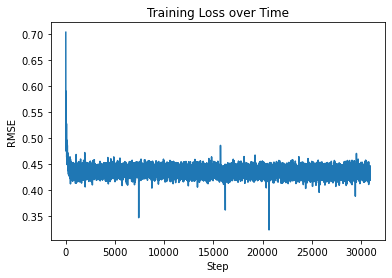

In [7]:
plt.plot(np.sqrt(np.asarray(batch_losses)), label='batch loss')
plt.ylabel("RMSE")
plt.xlabel("Step")
plt.title("Training Loss over Time")
plt.show()

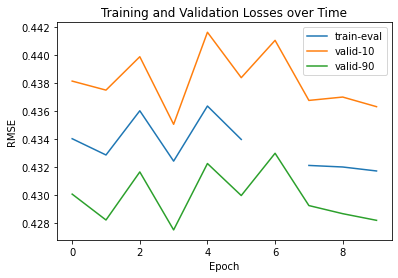

In [8]:
plt.plot(epoch_training_losses, label='train-eval')
plt.plot(epoch_validation10_losses, label='valid-10')
plt.plot(epoch_validation90_losses, label='valid-90')
plt.ylabel("RMSE")
plt.xlabel("Epoch")
plt.title("Training and Validation Losses over Time")
plt.legend()
plt.show()

## Visualizing predictions

In [9]:
s_pred, s_true = build_visualizable_structures(seqonly_model, d["train"], device, mode="seqs")

In [13]:
s_pred.to_3Dmol(10)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [14]:
s_true.to_3Dmol(10)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [15]:
torch.save(seqonly_model.state_dict(), "models/sidechainnetseq_model.pt")